In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as data_sets
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np
import sklearn.metrics as sk
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torchvision.datasets as data_sets
mnist_train_data=data_sets.MNIST('mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data=data_sets.MNIST('mnist', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Processing...
Done!


In [3]:
developement_size=18000
mnist_train_data, mnist_developement_set = random_split(mnist_train_data, [len(mnist_train_data) - developement_size, developement_size])

In [4]:
print('Train Dataset :', len(mnist_train_data), "\nValidation Dataset:" ,len(mnist_developement_set))

Train Dataset : 42000 
Validation Dataset: 18000


In [5]:
batch_size = 128

In [6]:
train_data_loader = DataLoader(dataset=mnist_train_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=True)
developement_data_loader = DataLoader(dataset = mnist_developement_set,batch_size = batch_size*2,num_workers=2,pin_memory=True)
test_data_loader = DataLoader(dataset=mnist_test_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=False)

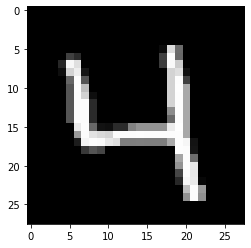

In [7]:
plt.imshow(mnist_train_data[0][0][0], cmap="gray")

Shape of Images: torch.Size([128, 1, 28, 28])


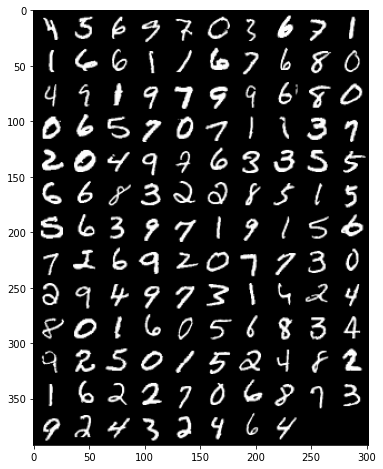

In [8]:
iterobj = iter(train_data_loader)
images, labels = iterobj.next()
print('Shape of Images:', images.shape)
plt.figure(figsize=(16,8))
plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))

In [9]:
class CNN_with_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_with_BatchNorm, self).__init__()         
        self.l1 = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
        self.l2= nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
      
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        nn.init.xavier_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(1000, 10)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, batch_data):
        batch_data = self.l1(batch_data)
        batch_data = self.l2(batch_data)
        batch_data = batch_data.reshape(batch_data.size(0), -1)
    
        batch_data = self.fc1(batch_data)
        batch_data = self.fc2(batch_data)
        return batch_data
    
    def train_each_batch(self, images, labels):
        result = self(images)
        loss = Loss(result, labels)
        return loss

    def develope_each_batch(self, images, labels):
        # images =  batch[0]
        # labels = batch[1]
        result = self(images)                   
        loss = Loss(result, labels)
        acc = accuracy(result, labels)      
        return {'loss_at_end_of_batch': loss, 'acc_at_end_of_batch': acc}
      
    def develope_at_end_of_epoch(self, results):
        losses_at_end_of_batch = [x['loss_at_end_of_batch'] for x in results]
        loss_at_end_of_epoch = torch.stack(losses_at_end_of_batch).mean()  
        accs_at_each_batch = [x['acc_at_end_of_batch'] for x in results]
        acc_at_end_of_epoch = torch.stack(accs_at_each_batch).mean() 
        return {'loss_at_end_of_epoch': loss_at_end_of_epoch.item(), 'acc_at_end_of_epoch': acc_at_end_of_epoch.item()}

    def display_metrics_at_end_of_epoch(self, epoch, result):
        print("acc_at_end_of_epoch: {:.4f}, loss_at_end_of_epoch: {:.4f}".format(result['acc_at_end_of_epoch'], result['loss_at_end_of_epoch']))

In [10]:
def accuracy(results, labels):
    _, predictions = torch.max(results, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

In [11]:
def develope(network, developement_data_loader):
    results = [network.develope_each_batch(images, labels) for j, (images, labels) in enumerate(developement_data_loader)]
    return network.develope_at_end_of_epoch(results)

In [12]:
network=CNN_with_BatchNorm()

In [14]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr = 0.001, momentum = 0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [16]:
def train(epochs, model, train_data_loader, developement_data_loader, optimizer):    
    epoch_metrics = []
    for epoch in range(epochs): 
        lr = scheduler.step()
        print('Epoch:', epoch,'Learning rate:', scheduler.get_lr())
        for j,(images, labels) in enumerate(train_data_loader):
            loss = model.train_each_batch(images, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = develope(model, developement_data_loader)
        model.display_metrics_at_end_of_epoch(epoch, result)
        epoch_metrics.append(result)
        print("\n")
    return epoch_metrics

In [17]:
metrics_history = train(10, network, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9685, loss_at_end_of_epoch: 0.1113


Epoch: 1 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9780, loss_at_end_of_epoch: 0.0773


Epoch: 2 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9798, loss_at_end_of_epoch: 0.0704


Epoch: 3 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9815, loss_at_end_of_epoch: 0.0627


Epoch: 4 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9833, loss_at_end_of_epoch: 0.0558


Epoch: 5 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9841, loss_at_end_of_epoch: 0.0535


Epoch: 6 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9842, loss_at_end_of_epoch: 0.0533


Epoch: 7 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9841, loss_at_end_of_epoch: 0.0504


Epoch: 8 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9853, loss_at_end_of_epoch: 0.0489


Epoch: 9 Learning rate: [1e-05]
acc_at_end_of_epoch: 0.9854, loss_at_end_of_epoch: 0.0468




In [20]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
else:
    device=torch.device("cpu")
print(device)

cpu


In [21]:
def test(network, test_data_loader):
  network.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    actuals = []
    predictions = []
    for images, labels in test_data_loader:
        images = Variable(images)
        results = network(images)
        prediction = results.argmax(dim=1, keepdim=True)
        actuals.extend(labels.view_as(prediction))
        predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

#     return (correct / total) * 100

In [22]:
# acc_of_test=test(network, test_data_loader)
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))

After Test : 
Confusion matrix:
[[ 974    0    0    0    0    1    1    1    3    0]
 [   0 1131    1    0    0    1    0    1    1    0]
 [   2    2 1019    0    1    0    0    4    4    0]
 [   1    0    0 1001    0    3    0    4    1    0]
 [   0    0    0    0  975    0    1    1    2    3]
 [   2    0    0    6    0  882    1    0    0    1]
 [   4    2    0    0    2    1  946    0    3    0]
 [   1    0    7    2    0    0    0 1012    1    5]
 [   4    1    2    1    1    2    0    2  957    4]
 [   3    2    0    0    9    2    0    3    2  988]]


In [23]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))

Accuracy score: 0.988500


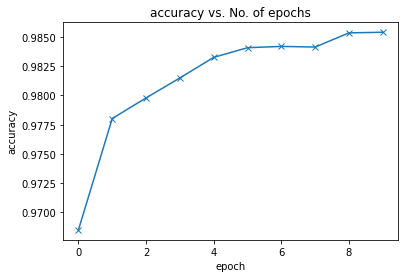

In [24]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

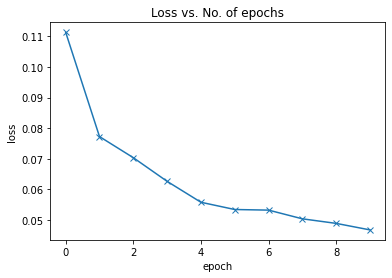

In [26]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

baseline- batch normalization

Batch Normalization (BatchNorm) is a method that enables faster and more stable training of neural networks. we add Batch Normalization after the activation function of the output layer or before the activation function of the input layer. this method, standardizes the inputs to a layer for each mini-batch. This stabilizes the learning process and reduces the number of training epochs required to train deep networks.

We have changed the learning rate to 0.001 and kept the schdular the same. We ran this for 10 epochs only, and achived an accuracy of 98.85, while batch normalization is supposed to increase the accuracy from the baseline implementation, we believe, if we had implemented more epochs we could have reached a much higher accuracy, but due to hardware limitation, this was the best accuracy we were able to achieve.